# 图神经网络GCN,GSAGE,GAT代码实现

该代码参照了知乎博主`小虎AI珏爷`的专栏`知识图谱&GNN`

In [2]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


## 图结构及相关数据形式
图用于建模对象（节点）之间的成对关系（边）。PyG中的单个图由torch_geometric.data.Data的一个实例描述。默认情况下包含以下属性：
* data.x: 节点特征矩阵，形状为[num_nodes,num_node_features]
* data.edge_index: COO格式的图连接，形状为 [2,num_edges]，类型为torch.long。
* data.edge_attr: 边特征矩阵，形状为 [num_edges,num_edge_features]
* data.y: 要训练的目标（可能具有任意形状）。比如，对于node-level任务，形状为[num_nodes, *]，对于graph-level任务，形状为[1, *] 。
* data.pos: 节点位置矩阵，形状为[num_nodes,num_dimensions]

In [3]:
import torch
from torch_geometric.data import Data
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index.t().contiguous())
#x:节点特征矩阵 
data

Data(x=[3, 1], edge_index=[2, 4])

## 相关数据集准备
PyG包含大量常用基准数据集，例如，所有Planetoid数据集（Cora、Citeseer、Pubmed），所有图分类数据集http://graphkernels.cs.tu-dortmund.de以及它们的清理版本、QM7和QM9数据集，以及一些3D网格/点云数据集，如FAUST、ModelNet10/40和ShapeNet。

数据集的初始化将自动下载其原始文件，并将其处理为前面描述的数据格式。比如，对于加载ENZYMES数据集，包含有600个graphs，有6个类别。

In [4]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

In [5]:
print('len(dataset)->',len(dataset))
#600个graph
print('dataset.num_classes->',dataset.num_classes)
#6个类别
print('dataset.num_node_features->',dataset.num_node_features)
#每个节点有三个特征

len(dataset)-> 600
dataset.num_classes-> 6
dataset.num_node_features-> 3


In [6]:
data = dataset[0]
data

Data(edge_index=[2, 168], x=[37, 3], y=[1])

In [7]:
data.is_undirected()

True

In [8]:
'''划分数据集'''
train_dataset = dataset[:540]
test_dataset = dataset[540:]
print(train_dataset)
print(test_dataset)

ENZYMES(540)
ENZYMES(60)


In [9]:
'''打乱数据集'''
dataset = dataset.shuffle()
print(dataset)
'''另外一种打乱的方式'''
perm = torch.randperm(len(dataset))
dataset = dataset[perm]
print(dataset)

ENZYMES(600)
ENZYMES(600)


### $Cora$数据集

In [10]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [11]:
print('len(dataset)->',len(dataset))
print('dataset.num_classes->',dataset.num_classes)
print('dataset.num_node_features->',dataset.num_node_features)

len(dataset)-> 1
dataset.num_classes-> 7
dataset.num_node_features-> 1433


In [13]:
data = dataset[0]
print(data)
"""
train_mask:训练集的mask向量。
val_mask：验证集的mask向量。
test_mask：测试集的mask向量。
"""
print('data.is_undirected()->',data.is_undirected())
print('data.train_mask.sum().item()->',data.train_mask.sum().item())
print('data.val_mask.sum().item()->',data.val_mask.sum().item())
print('data.test_mask.sum().item()',data.test_mask.sum().item())

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
data.is_undirected()-> True
data.train_mask.sum().item()-> 140
data.val_mask.sum().item()-> 500
data.test_mask.sum().item() 1000


### 微批次

In [14]:
'''神经网络通常以分批方式进行训练。PyG通过创建稀疏块对角邻接矩阵，
并在节点维度中连接特征矩阵和目标矩阵，在小批量上实现并行化。'''
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [16]:
for batch in loader:
    print('batch->',batch)
    print('batch.num_graphs->',batch.num_graphs)
    break
'''batch是一个列向量，它将每个节点映射到批次中各自的图'''

batch-> DataBatch(edge_index=[2, 4108], x=[1023, 21], y=[32], batch=[1023], ptr=[33])
batch.num_graphs-> 32


### 数据变换
Transforms是torchvision中变换图像和执行增强的常用方法。PyG自带了自己的transforms，它期望一个数据对象作为输入，并返回一个新的转换后的数据对象。，可以使用`torch_geometric.transforms.Compose`来组合多个转换操作。Transforms操作可以在保存数据集到磁盘之前或者访问数据集中的graph之前进行实现。

可以通过变换从3D点云（ShapeNet）生成最近邻图，将点云数据集转换为图数据集。

In [19]:
'''通过变换从3D点云（ShapeNet）生成最近邻图，将点云数据集转换为图数据集'''
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'],
                    pre_transform=T.KNNGraph(k=6))

dataset[0]

Using existing file shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Extracting \tmp\ShapeNet\shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1], edge_index=[2, 15108])

In [20]:
""" 使用transformer参数随机增强数据对象。 """
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'],
                    pre_transform=T.KNNGraph(k=6),
                    transform=T.RandomJitter(0.01))

dataset[0]

Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1], edge_index=[2, 15108])

# 谱方法$GCN$实现（$Cora$引文节点分类例子）

$f\left(H^{(l)},A\right)=\sigma\left(\hat D^{-\frac12}\hat A\hat D^{-\frac12}H^{(l)}W^{(l)}\right)$

其中$\hat{A}=A+I$,其中$I$是单位矩阵，$\widehat{D}$是$A$的对角节点度矩阵

In [21]:
""" 加载数据 """
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [22]:
""" 实现两层的GCN """
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        # in_channels: int, out_channels: int
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        #定义前向运算过程
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
        #其实就是对softmax值进行一个log

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
# 用于将张量或模型移动到指定的设备上进行计算
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
#params,lr,weight_decay：权重衰减（L2惩罚项）

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [23]:
""" 对模型进行评估 """
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7970


In [ ]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
#PRW：https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)  #GraphSage / GAT
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))  

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            '''
            当使用num heads>1应用GAT时，需要修改conv层的输入和输出维度（self.convs），确保下一层的输入dim为num_heads乘以上一层的输出尺寸。
提示：如果想实现多头（multi-heads），需要在建立self.convs时改变self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim))和post-message-passing中第一个nn.Linear(hidden_dim * num_heads, hidden_dim) 
         '''
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)
            

        x = self.post_mp(x)

        if self.emb == True:
            return x

        #Applies a softmax followed by a logarithm.
        #https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.log_softmax
        return F.log_softmax(x, dim=1)
       

    def loss(self, pred, label):
        #The negative log likelihood loss.
        #https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#nll_loss
        return F.nll_loss(pred, label) 

# 归纳式GCN GraphSAGE实现

GraphSAGE有两阶段聚合：
* 阶段一 聚合节点的邻居:

    $\mathbf{h}_{N(v)}^{(l)}\leftarrow\operatorname{AGG}\left(\left\{\mathbf{h}_{u}^{(l-1)},\forall u\in N(v)\right\}\right)$
* 阶段二 更进一步聚合节点自己和邻居信息

    $\mathbf{h}_n^{(l)}\leftarrow\sigma\left(\mathbf{W}^{(l)}\cdot\mathrm{CONCT}\left(\mathbf{h}_0^{(l-1)},\mathbf{h}_{N(v)}^{(l)}\right)\right)$

实现一个通用GNN模块的实现，该模块可以插入任何自定义组件，包括GraphSage、GAT等

In [30]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
#PRW：https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)  #GraphSage / GAT
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))  

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            '''
            当使用num heads>1应用GAT时，需要修改conv层的输入和输出维度（self.convs），确保下一层的输入dim为num_heads乘以上一层的输出尺寸。
提示：如果想实现多头（multi-heads），需要在建立self.convs时改变self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim))和post-message-passing中第一个nn.Linear(hidden_dim * num_heads, hidden_dim) 
         '''
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)
            

        x = self.post_mp(x)

        if self.emb == True:
            return x

        #Applies a softmax followed by a logarithm.
        #https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.log_softmax
        return F.log_softmax(x, dim=1)
       

    def loss(self, pred, label):
        #The negative log likelihood loss.
        #https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#nll_loss
        return F.nll_loss(pred, label)  

In [24]:
class GraphSage(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.lin_l = None
        self.lin_r = None

        ############################################################################
        #定义下面的message和update 函数所需的层。
        # self.lin_l 是应用于中心节点嵌入的线性变换。
        # self.lin_r 是应用于来自邻居的聚合message的线性变换。
       
        self.lin_l=Linear(in_channels,out_channels)  #Wl
        self.lin_r=Linear(in_channels,out_channels)  #Wr

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""
        out = None
        ############################################################################
        # 实现消息传递以及任何后处理（更新规则）
        # 1. 首先调用propagate函数来进行消息传递。
        #    1.1 有关更多信息，请参见此处: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 对中心（x_central）和邻居（x_neighbor）节点使用相同的表示，即x=（x，x）进行传播。
        # 2. 使用skip connection更新节点嵌入。
        # 3. 如果需要归一化, 使用L-2 normalization (定义在torch.nn.functional)

        out=self.propagate(edge_index,x=(x,x),size=size)
        x=self.lin_l(x)
        out=self.lin_r(out)
        out=out+x
        if self.normalize:
            out=F.normalize(out)
        ############################################################################
        return out

    def message(self, x_j):
        out = None
        #propagte传入的中心节点和邻居节点的表示一样。
        out=x_j
        return out

    def aggregate(self, inputs, index, dim_size = None):
        out = None
        # 沿其索引节点数的维度.
        node_dim = self.node_dim
        ############################################################################
        # 实现平均聚合.
        # 请参见此处，了解如何使用torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        out=torch_scatter.scatter(inputs,index,node_dim,dim_size=dim_size,reduce='mean')
        ############################################################################
        return out

# 图注意力网络 GAT实现

In [25]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############################################################################
        # self.lin_l是在消息传递之前应用于嵌入的线性变换。
        # 注意线性层的尺寸，因为我们使用的是多头注意力。
       
        self.lin_l=Linear(in_channels,heads*out_channels) 

        ############################################################################

        self.lin_r = self.lin_l  #W_r

       

        ############################################################################
        # 定义注意力参数，需要考虑多头的情况
        self.att_l = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_r = Parameter(torch.Tensor(1, heads, out_channels))

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)
        #https://pytorch.org/docs/stable/_modules/torch/nn/init.html#xavier_uniform_

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        ############################################################################
        # 主要逻辑实现函数，实现消息传递、预处理、后处理
        # 1. 首先对节点嵌入应用线性变换，并将其拆分为多头。对源节点和目标节点使用相同的表示，但应用不同的线性权重（W_l和W_r）
        # 2. 计算中心节点（alpha_l）和相邻节点（alpha_r）的alpha向量
        # 3. 调用propagate函数进行消息传递。使得alpha = (alpha_l, alpha_r)传递参数。
        # 4. 将输出转换回N*d的形状。

        x_l=self.lin_l(x)
        x_r=self.lin_r(x)
        x_l=x_l.view(-1,H,C)
        x_r=x_r.view(-1,H,C)
        alpha_l = (x_l * self.att_l).sum(axis=1)  #*是逐元素相乘
        alpha_r = (x_r * self.att_r).sum(axis=1)
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r),size=size)
        out = out.view(-1, H * C)
        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # 实现message功能。将注意力放在message中
        # 1. 使用alpha_i和alpha_j计算最终注意力权重，并应用leaky Relu。
        # 2. 为所有节点计算邻居节点上的softmax。使用torch_geometric.utils.softmax而不是pytorch中的softmax。
        # 3. 对注意权重（alpha）应用dropout。
        # 4. 增加嵌入和注意力权重，输出应为形状 E * H * d。
        # 5. ptr (LongTensor, 可选):如果给定，则根据CSR表示中的排序输入计算softmax。
       
        
        #alpha：[E, C]
        alpha = alpha_i + alpha_j  #leaky_relu的对象
        alpha = F.leaky_relu(alpha,self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        #https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch-geometric-utils
        #https://github.com/rusty1s/pytorch_geometric/blob/master/torch_geometric/utils/softmax.py
       
        
        alpha = F.dropout(alpha, p=self.dropout, training=self.training).unsqueeze(1)  #[E,1,C]
        out = x_j * alpha #[E,H,C]

        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # 实现聚合函数
        # 请参见此处，了解如何使用 torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # 请注意“reduce”参数与GraphSAGE中的参数不同
       
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce='sum')

        ############################################################################
    
        return out

In [26]:
""" 构建优化器 """
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [27]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("节点分类任务，数据集大小:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [28]:
def main():
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage', 'GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses = train(dataset, args) 

            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()

节点分类任务，数据集大小: 140
Maximum accuracy: 0.776
Minimum loss: 0.114881731569767
节点分类任务，数据集大小: 140
Maximum accuracy: 0.78
Minimum loss: 0.0279531292617321


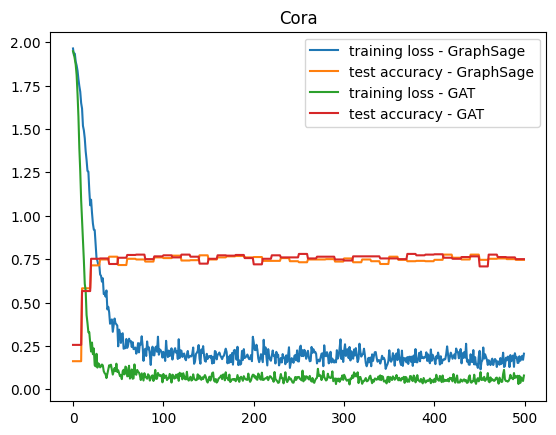

In [31]:
main()